In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pytz
import sklearn
import scipy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder



from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ModuleNotFoundError: No module named 'UMAP'

In [2]:
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
   
# Suppress SettingWithCopyWarning


In [3]:
data = pd.read_csv('CPS.csv')

In [4]:
# Select and rename relevant columns for analysis out of the 356 original columns 
selected_columns = {
    # Household Information
    'HUFINAL': 'interview_outcome',
    'hrnumhou': 'household_members',  # Number of members in a household
    'hefaminc' : 'family_income',

    # Education and Certification Details
    'peschlvl': 'highest_level_of_school',  # Highest level of school 
    'peeduca': 'education_level',  # Highest level of education completed
    'peedegr': 'highest_degree_earned',  # Highest degree earned
    'petrain': 'received_job_training',  # Received job training past high school
    'pecert1': 'professional_certification1',  # Professional certification 1
    'pecert2': 'cert_issued_by_state_or_gov',  # Is certificate issued by the state or the federal government?
    'pecert3': 'is_cert_required',  # Is certification needed for the job?

    # Employment and Income Details
    'pemlr': 'employment_status',  # Employment status
    'prunedor': 'duration_of_unemployment',  # Duration of unemployment
    'hefaminc': 'family_income',  # Family income
    'primind1': 'primary_industry_code_job1',  # Primary industry code for job 1
    'peio1icd': 'industry_code_job1',  # Industry code for job 1
    'ptio1ocd': 'occupation_code_job1',  # Occupation code for job 1
    'primind2': 'primary_industry_code_job2',  # Primary industry code for job 2
    'peio2icd': 'industry_code_job2',  # Industry code for second job 
    'ptio2ocd': 'occupation_code_job2',  # Occupation code for job 2
    'puwk': 'did_work_last_week',  # Did the individual work last week
    
    # Earnings
    'pternh1c': 'earnings_first_job',  # Earnings from the first job
    'pthr': 'total_hours_worked',  # Total hours worked
    'pternwa': 'weekly_earnings',  # Weekly earnings

    # Demographic Variables
    'ptdtrace': 'race',  # Race
    'prtage': 'age', 
    'pesex': 'gender',  # Gender
    'prcitshp': 'citizenship_status',  # Citizenship status

     # Geographic Information
    'gestfips': 'state_code',  # State FIPS code
    

     # Work Arrangement and Preferences
    'pehruslt': 'usual_hours_worked',  # Usual hours worked per week
    'pewa': 'work_at_home',  # Ability or frequency of working from home
    'pewm': 'work_multiple_jobs',  # Working multiple jobs
    
   
     # Job Search and Unemployment Details
    'pruntype': 'reason_for_unemployment',  # Reason for unemployment
    'pulaydtx': 'weeks_looking_for_work',  # Weeks spent looking for work
    'pulkm1': 'primary_method_of_job_search',  # Primary method of job search
    'puhrck12': 'job_search_method',  # Job search method

     # Health and Disability
    'pedisabl': 'disability_status',  # Disability status
    'pehspnon': 'health_status_impacting_work',  # Health status impacting work
    
}

In [5]:
# Filter the dataset to keep only the selected columns, verifying they exist
data = data[[col for col in selected_columns if col in data.columns]].rename(columns=selected_columns)


In [6]:
# Replace NaN values with -1
data.fillna(-1, inplace=True)

In [7]:
# Impute -1 in Family income with weekly earning values when family income is -1
data.loc[(data['weekly_earnings'] != -1) & (data['family_income'] == -1), 'family_income'] = data['weekly_earnings']

In [8]:
data.shape

(126784, 26)

In [9]:
data = data.copy()
data = data.loc[(data['family_income'] != -1)]

In [10]:
data.shape

(99250, 26)

In [11]:
# Calculate the percentage of -1 for each column and drop columns with more than 25% -1 values
columns_to_drop = [column for column in data.columns if (data[column] == -1).sum() / len(data) > 0.40]

# Drop these columns
data.drop(columns=columns_to_drop, inplace=True)


In [12]:
data.shape

(99250, 13)

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 99250 entries, 0 to 126762
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   interview_outcome             99250 non-null  int64  
 1   household_members             99250 non-null  int64  
 2   family_income                 99250 non-null  int64  
 3   education_level               99250 non-null  float64
 4   professional_certification1   99250 non-null  float64
 5   employment_status             99250 non-null  float64
 6   total_hours_worked            99250 non-null  int64  
 7   race                          99250 non-null  float64
 8   age                           99250 non-null  float64
 9   gender                        99250 non-null  float64
 10  citizenship_status            99250 non-null  float64
 11  state_code                    99250 non-null  int64  
 12  health_status_impacting_work  99250 non-null  float64
dtypes: fl

In [14]:
# Change float to category
categorical_columns = ['family_income', 'interview_outcome', 'education_level', 'professional_certification1', 'employment_status', 'race', 'gender', 'citizenship_status', 'state_code', 'health_status_impacting_work']
for col in categorical_columns:
    data[col] = data[col].astype('category')

In [15]:
# Change float to category
int32_columns = ['household_members', 'total_hours_worked', 'age', 'state_code']
for col in int32_columns:
    data[col] = data[col].astype('int32')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99250 entries, 0 to 126762
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   interview_outcome             99250 non-null  category
 1   household_members             99250 non-null  int32   
 2   family_income                 99250 non-null  category
 3   education_level               99250 non-null  category
 4   professional_certification1   99250 non-null  category
 5   employment_status             99250 non-null  category
 6   total_hours_worked            99250 non-null  int32   
 7   race                          99250 non-null  category
 8   age                           99250 non-null  int32   
 9   gender                        99250 non-null  category
 10  citizenship_status            99250 non-null  category
 11  state_code                    99250 non-null  int32   
 12  health_status_impacting_work  99250 non-null  cate

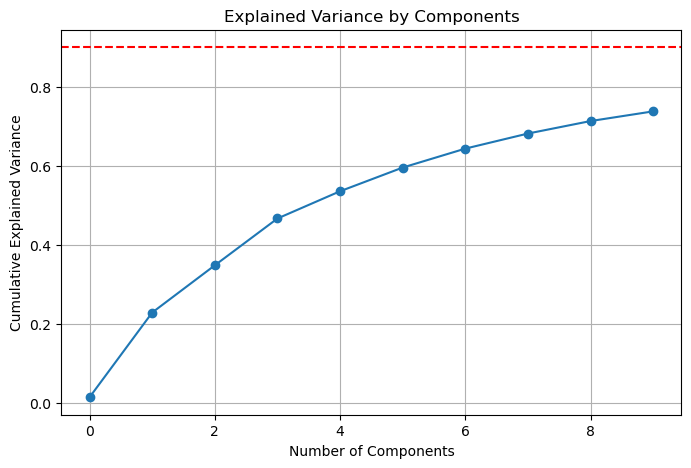

Eigenvalues:
 [0.11312121 1.80665092 1.00768667 0.99881171 0.58135764 0.50548438
 0.40412008 0.32160143 0.26641786 0.2067183 ]
Number of Components with Eigenvalues > 1: 2


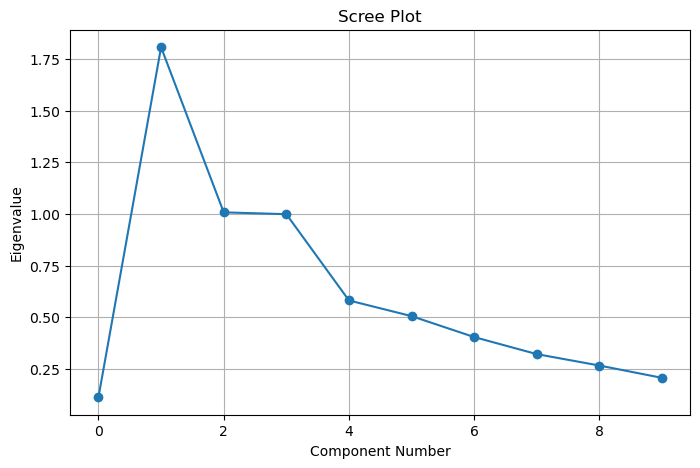

In [19]:
# Define transformers for the pipeline
categorical_features = data.select_dtypes(include=['category']).columns.tolist()
numeric_features = data.select_dtypes(include=['int32', 'float64']).columns.tolist()

# Preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline with preprocessor and TruncatedSVD
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=10))  # Using TruncatedSVD instead of PCA
])

# Fit the model using the pipeline
pipeline.fit(data)

# Access the TruncatedSVD from the pipeline
svd = pipeline.named_steps['svd']
explained_variance = np.cumsum(svd.explained_variance_ratio_)

# Plotting Cumulative Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--')  # Line at 90% variance
plt.show()

# Eigenvalues and Scree Plot from TruncatedSVD
eigenvalues = svd.explained_variance_
print("Eigenvalues:\n", eigenvalues)
num_components_kaiser = np.sum(eigenvalues > 1)
print("Number of Components with Eigenvalues > 1:", num_components_kaiser)

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(eigenvalues, marker='o')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.show()


Based on the two plots, we can derive the optimal number of principal components to retain by looking at both the cumulative explained variance plot and the scree plot.

**Analyzing the Cumulative Explained Variance Plot**

From the cumulative explained variance plot, the number of components is chosen where the cumulative variance reaches a certain threshold, typically around 90-95%. In the plot, the 80% threshold seems to be crossed around the component number 7 or 8. This indicates that approximately 80% of the variance be captured by the first 8 components.

**Analyzing the Scree Plot**

The scree plot helps us identify the "elbow," where the eigenvalues begin to flatten out significantly, indicating diminishing returns on adding more components. It appears the elbow occurs around component  3, after which the decline in eigenvalue magnitude becomes more gradual.

**Optimal Component Number Recommendation**

Given the information from both plots:
We can choose around 7 or 8 components based on the explained variance plot; however, according to the scree plot, the first elbow occurs at 3; therefore,  since our priority is a more interpretable model, and we're willing to sacrifice some amount of variance explained for a more significant dimensionality reduction, then choosing 4 components would be optimal. Balancing the trade-off between information retention (explained variance) and model simplicity is essential.  

In [20]:
# Preprocessor for transforming data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pipeline with preprocessor and TruncatedSVD set to 4 components
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components=4))  # Adjusted number of components
])


# Use fit_transform to both fit the pipeline and transform the data
transformed_data = pipeline.fit_transform(data)

# Access the TruncatedSVD from the pipeline
svd = pipeline.named_steps['svd']


# Calculate loadings similar to PCA
loadings = svd.components_.T * np.sqrt(svd.explained_variance_)

# Prepare the dataframe to display loadings
# Retrieve feature names for the transformed categorical variables
transformed_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
features = list(numeric_features) + list(transformed_feature_names)
loading_matrix = pd.DataFrame(loadings, columns=[f'SV{i+1}' for i in range(svd.n_components)], index=features)

print("Loadings:\n", loading_matrix)

Loadings:
                                        SV1       SV2       SV3       SV4
household_members                -0.007915  0.796812  0.039389 -0.016851
total_hours_worked                0.000061 -0.019806  0.504190  0.862770
age                               0.008705 -0.898601  0.012078 -0.023575
state_code                        0.003127 -0.001087 -0.863603  0.499578
interview_outcome_1               0.007888 -0.006573  0.010630  0.002212
...                                    ...       ...       ...       ...
citizenship_status_3.0            0.001001 -0.000736  0.001159 -0.000245
citizenship_status_4.0            0.007986 -0.018396  0.020170 -0.010968
citizenship_status_5.0            0.007692  0.012339  0.013460 -0.007700
health_status_impacting_work_1.0  0.020127  0.077562  0.037020 -0.023888
health_status_impacting_work_2.0  0.133462 -0.011021 -0.017321  0.012765

[89 rows x 4 columns]


In [21]:
for l in loading_matrix.index:
    print(l)

household_members
total_hours_worked
age
state_code
interview_outcome_1
interview_outcome_2
interview_outcome_4
interview_outcome_5
interview_outcome_201
interview_outcome_203
family_income_1
family_income_2
family_income_3
family_income_4
family_income_5
family_income_6
family_income_7
family_income_8
family_income_9
family_income_10
family_income_11
family_income_12
family_income_13
family_income_14
family_income_15
family_income_16
education_level_-1.0
education_level_31.0
education_level_32.0
education_level_33.0
education_level_34.0
education_level_35.0
education_level_36.0
education_level_37.0
education_level_38.0
education_level_39.0
education_level_40.0
education_level_41.0
education_level_42.0
education_level_43.0
education_level_44.0
education_level_45.0
education_level_46.0
professional_certification1_-1.0
professional_certification1_1.0
professional_certification1_2.0
employment_status_-1.0
employment_status_1.0
employment_status_2.0
employment_status_3.0
employment_status_

The loading matrix you've provided shows the contribution of each original feature (including those generated from categorical variables) to each of the four singular value decomposition (SVD) components. This matrix is key for understanding the structure and interpretation of the data in reduced-dimensional space. Here's how to interpret and analyze this information:

Interpreting the Loadings:
SV1, SV2, SV3, SV4 Columns: Each column represents a singular vector (component) from the SVD. The values in these columns are the loadings, which quantify how much each original feature contributes to the direction of the corresponding component.
High Absolute Values: High values (both positive and negative) indicate strong associations with the component. For example:
total_hours_worked has a strong loading in SV4 (0.997454), indicating that this feature significantly defines the fourth component, perhaps representing a dimension mostly characterized by work hours.
state_code has a strong negative loading in SV3 (-0.921919), suggesting that this component is largely defined in opposition to the encoded state, possibly capturing regional differences in the data.
Signs of Loadings: The sign (positive or negative) of a loading indicates the direction of the correlation between the feature and the component. Features with similar directions on the same component are positively correlated with each other in that dimension.
Diverse Contributions:
Household Dynamics and Regional Effects: Features like household_members and state_code contribute to different components, suggesting that these components might be capturing aspects related to household size and geographical/regional differences.
Health and Citizenship: The contributions of features related to health status and citizenship indicate how these might differentiate the data along other dimensions.
Using the Loadings:
Dimensionality Reduction: This reduced representation can be used to visualize the data, input into other machine learning models, or to identify underlying patterns.
Feature Selection and Engineering: By examining which features contribute most to the components that explain a significant amount of variance, you can potentially identify important features or reduce redundancy in the dataset.
Interpretive Modeling: For more interpretable models, you might focus on components that capture the most variance and understand how original features contribute to these components.
Next Steps:
Visualize: Consider plotting these components against each other to visualize clusters or outliers in your dataset.
Cluster Analysis: You can use the transformed data for clustering to see if similar observations group together in the reduced space, potentially revealing latent groups.
Regression/Classification Models: Use the component scores as inputs for further modeling to predict outcomes of interest, especially when the original feature space is too large or correlated.
The loading matrix is a powerful tool for exploring how complex data can be summarized into fewer dimensions while retaining meaningful patterns.

In [22]:
print(preprocessor)
# Ensure that 'categorical_features' actually includes the categorical columns you expect to encode
print(categorical_features)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['household_members', 'total_hours_worked',
                                  'age', 'state_code']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['interview_outcome', 'family_income',
                                  'education_level',
                                  'professional_certification1',
                                  'employment_status', 'race', 'gender',
                                  'citizenship_status',
                                  'health_status_impacting_work'])])
['interview_outcome', 'family_income', 'education_level', 'professional_certification1', 'employment_status', 'race', 'gender', 'citizenship_status', 'health_status_impacting_work']


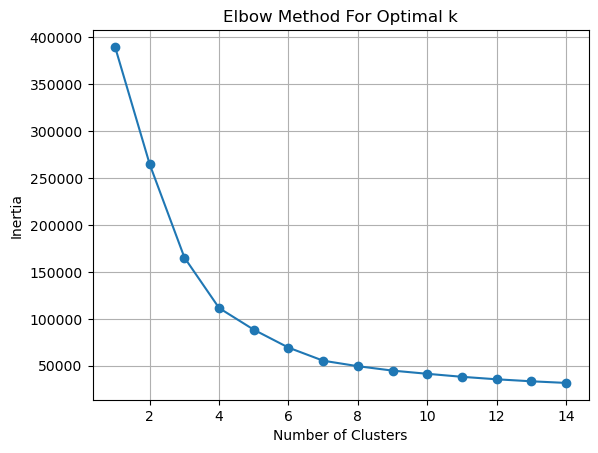

In [23]:
inertia = []
range_values = range(1, 15)  # Testing 1-14 clusters

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(transformed_data)
    inertia.append(kmeans.inertia_)

plt.plot(range_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [24]:
# optimal_k is the chosen number of clusters
optimal_k = 4  # k chosen from the elbow method or other criterion
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(transformed_data)

#  these cluster labels to your original or reduced DataFrame for further analysis
data['Cluster'] = clusters 

Cluster centers:
         PC1       PC2        PC3        PC4
0  2.170903 -0.535392   0.816606  -0.518877
1  2.262232 -0.633144  -0.731088   0.378890
2  1.923233  1.869421  -0.031693   0.000014
3  2.162498 -0.720368  15.360402  26.116967


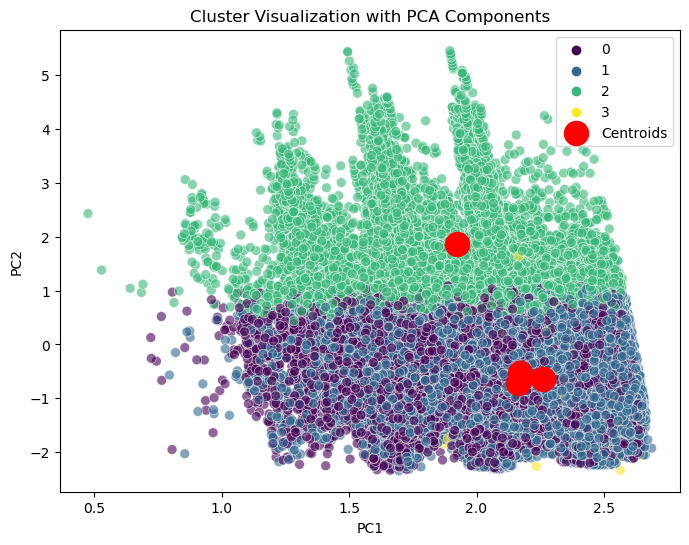

In [25]:
# Viewing cluster centers
centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(4)])
print("Cluster centers:\n", centers)

# Visualizing clusters (if reduced to 2 or 3 dimensions earlier)
import seaborn as sns
if transformed_data.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.6)
    plt.scatter(centers.iloc[:, 0], centers.iloc[:, 1], s=300, c='red', label='Centroids')
    plt.xlabel('SV1')
    plt.ylabel('SV2')
    plt.title('Cluster Visualization with SV Components')
    plt.legend()
    plt.show()

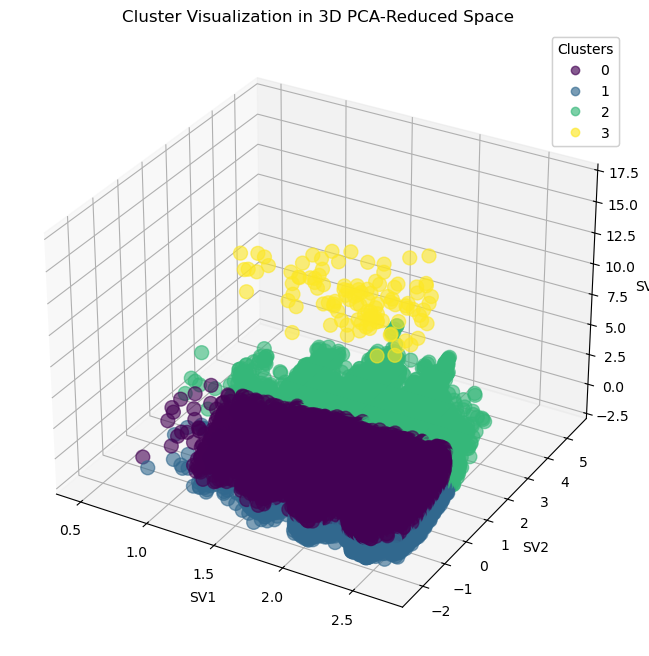

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], c=clusters, cmap='viridis', s=100, alpha=0.6)
ax.set_xlabel('SV1')
ax.set_ylabel('SV2')
ax.set_zlabel('SV3')
plt.title('Cluster Visualization in 3D PCA-Reduced Space')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.show()

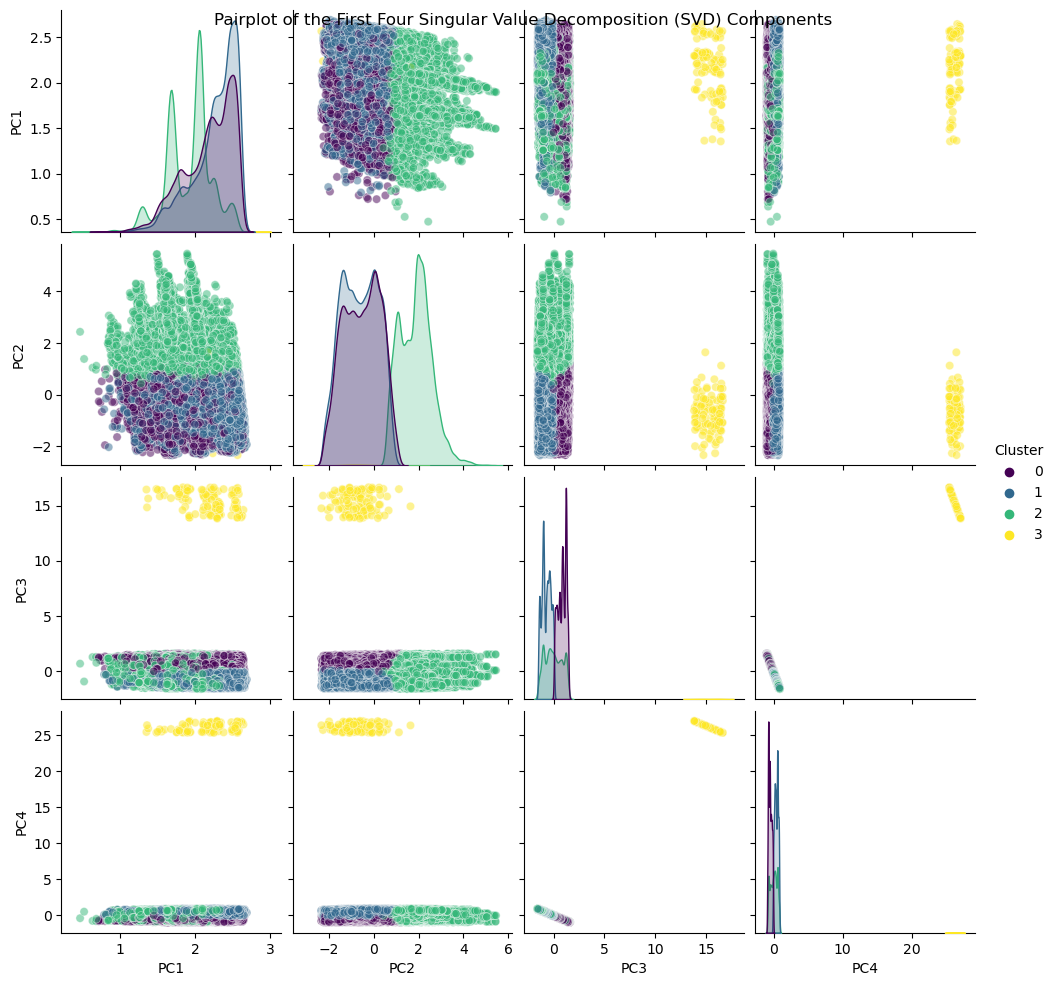

In [28]:
# Create a DataFrame with the first few principal components and cluster labels
pca_df = pd.DataFrame(data=transformed_data[:, :4], columns=[f'PC{i+1}' for i in range(4)])
pca_df['Cluster'] = clusters

sns.pairplot(pca_df, hue='Cluster', palette='viridis', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of the First Four Singular Value Decomposition (SVD) Components', verticalalignment='top')
plt.show()

In [ ]:
# List of columns you want to visualize, adjust as necessary
columns_to_visualize = ['household_members', 'age']

for column in columns_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=data)
    plt.title(f'Distribution of {column} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()

ModuleNotFoundError: No module named 'umap'